In [36]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp

# set display options
pd.set_option('display.max_columns', None)

In [37]:
#import dataset
X_train = pd.read_pickle('./data/X_train.pkl')
y_train = pd.read_pickle('./data/y_train.pkl')

X_test = pd.read_pickle('./data/X_test.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')


In [38]:
X_train.head()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,year,population_change,natural_amenity_rank
0,2,12955.026735,13218.012969,8087.700338,2.207342,1466.760964,4.1,0.800000,0.700000,94382.0,41.7,0.540569,0.090324,0.097815,0.240713,0.5942,68995.0,0.044332,29.4,0.063561,0.027569,0.227130,0.176167,2017.0,3.516101,3.0
1,2,12229.733392,12425.949436,8802.076944,2.306131,666.407524,5.1,2.200000,1.900000,70103.0,31.2,0.810379,0.028273,0.065603,0.067843,0.4959,69983.0,0.050289,25.5,0.032352,0.026803,0.367145,0.168951,2017.0,2.035550,3.0
2,2,36911.968549,37386.221023,16769.735345,2.357187,4935.854711,4.1,0.800000,0.700000,61514.0,42.6,0.720308,0.033488,0.108479,0.109406,0.5630,114641.0,0.053383,23.9,0.047436,0.017541,0.257990,0.245017,2017.0,1.228203,3.0
3,2,9646.843766,9752.248380,7788.304331,2.834092,483.195408,4.6,2.127322,2.155775,105854.0,34.8,0.511828,0.071570,0.180296,0.210082,0.3699,48249.0,0.057867,26.5,0.051911,0.042341,0.223761,0.111106,2017.0,0.922800,3.0
4,2,19307.990981,19603.087694,10784.215023,1.708793,1256.679720,5.1,2.200000,1.900000,70225.0,30.2,0.793848,0.042093,0.068466,0.067198,0.5200,73991.0,0.027554,24.1,0.034660,0.013670,0.347925,0.154859,2017.0,4.675665,3.0


In [39]:
X_train.describe()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,year,population_change,natural_amenity_rank
count,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.000000,18273.0,18273.000000,18273.000000
mean,2.333388,7344.888573,7445.221561,4742.541198,2.632281,455.256207,4.229563,1.855239,1.309765,38890.467739,36.111673,0.502931,0.154068,0.085635,0.222656,0.464850,36443.958682,0.056616,31.386291,0.129203,0.049108,0.163115,0.077859,2017.0,1.712490,4.135446
std,0.942148,7382.173494,7479.043288,3268.597377,1.494023,764.666435,0.928697,0.776579,0.671681,19178.692249,5.234877,0.254833,0.192211,0.100771,0.206171,0.052557,18918.096497,0.036919,4.963939,0.054471,0.018718,0.082522,0.051181,0.0,5.060268,1.483228
min,1.000000,940.704324,950.467225,803.082287,0.348675,4.058808,2.100000,0.300000,0.000000,2029.000000,21.000000,0.004824,0.000000,0.000000,0.003516,0.312100,10490.000000,0.000000,19.000000,0.008520,0.006083,0.014644,0.002431,2017.0,-0.931333,1.000000
25%,2.000000,3473.688172,3509.926809,2685.996373,1.602828,114.707771,3.500000,1.400000,0.700000,24988.000000,32.900000,0.304375,0.031047,0.022590,0.072116,0.427600,23671.000000,0.032627,27.800000,0.085970,0.035705,0.098913,0.038847,2017.0,-0.134263,3.000000
50%,2.000000,5000.597510,5069.228283,3674.103420,2.364993,240.371641,4.100000,1.900000,1.200000,35885.000000,35.700000,0.541596,0.078832,0.049879,0.152011,0.459600,31067.000000,0.049478,30.700000,0.130057,0.047857,0.152919,0.067361,2017.0,0.323286,3.000000
75%,3.000000,8297.599341,8440.823937,5824.217112,3.457481,499.498026,4.800000,2.200000,1.900000,49354.000000,39.100000,0.713452,0.189455,0.108076,0.304789,0.496700,45388.000000,0.072889,34.200000,0.169692,0.060931,0.218491,0.107971,2017.0,1.362111,5.000000
max,4.000000,65092.982114,65834.988801,35905.455475,19.330661,8394.169074,9.200000,6.400000,3.600000,114647.000000,67.400000,0.973506,0.982393,0.726602,0.977026,0.685700,154723.000000,0.487710,50.000000,0.279457,0.126473,0.462318,0.344235,2017.0,67.122977,7.000000


In [40]:
#show columns with missing values
print(X_train.columns[X_train.isnull().any()])
print(X_test.columns[X_test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


In [41]:
X_train.shape

(18273, 26)

In [42]:
y_train.shape

(18273,)

In [43]:
X_test.shape

(17396, 26)

In [44]:
y_test.shape

(17396,)

In [45]:
X_train.columns

Index(['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',
       'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'total_pop', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'gini_index', 'income_per_capita',
       'vacant_housing_units_for_rent', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'year', 'population_change', 'natural_amenity_rank'],
      dtype='object')

In [46]:
X_test.columns

Index(['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',
       'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'total_pop', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'gini_index', 'income_per_capita',
       'vacant_housing_units_for_rent', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'year', 'population_change', 'natural_amenity_rank'],
      dtype='object')

In [47]:
X_train.drop(columns = ['total_pop','year'], inplace=True)

X_test.drop(columns = ['total_pop','year'], inplace=True)

In [25]:
#feature selection
model_cols = ['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',\
              'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89','MortDeliq90']

X_train = X_train[model_cols]

X_test = X_test[model_cols]

## Model Generation

In [48]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection

In [49]:
lm = LinearRegression()

lm.fit(X_train, y_train)

print("Train Score: %.4f" % lm.score(X_train, y_train))
print("Test Score:  %.4f" % lm.score(X_test, y_test))

print(lm.score(X_train, y_train)- lm.score(X_test, y_test))



Train Score: 0.6772
Test Score:  0.0585
0.61871504604187


In [50]:
lm.intercept_, lm.coef_

(-998.7037973256768,
 array([-1.52898291e+01,  1.06258171e+00, -1.08879383e+00,  4.31478558e-02,
         4.89777943e+01,  2.62858205e-01, -7.14965990e+01, -2.16507300e+02,
         1.34428214e+02,  1.67733102e+00, -2.96815164e+02,  2.21197792e+02,
         1.26933357e+03,  9.37095453e+02,  1.60684247e+03,  1.54432520e-02,
        -2.23443558e+03,  2.31680474e+01,  2.29210718e+03, -1.45505699e+03,
         1.32779261e+03,  2.11029125e+03,  3.81395898e-01,  5.51955040e+01]))

In [33]:
from sklearn.model_selection import cross_val_score
print(np.sqrt(-1* cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs =-1)))

[499.29010841 505.20146149 528.07488732 496.89362375 510.53893443]


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

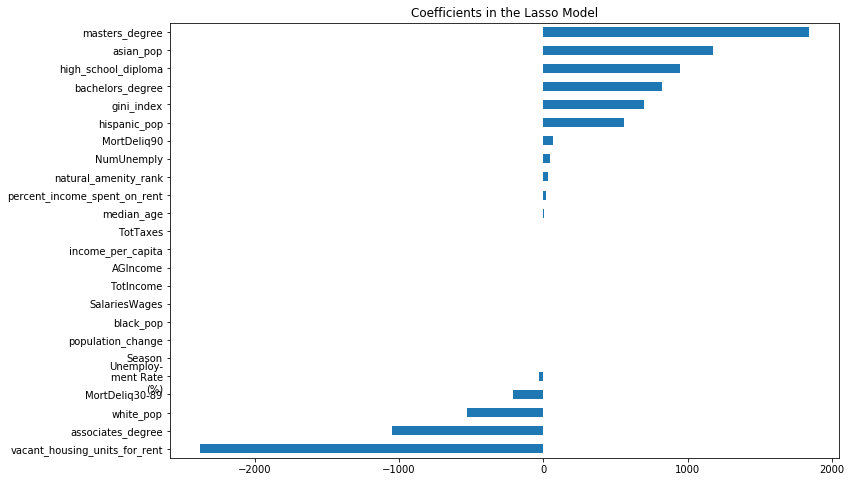

In [53]:
# param_grid={'alpha': np.logspace(-5, -3, 100)}
# grid_search = model_selection.GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# print("Cross Validation")
# print("-" * 20)
# print("Best parameter: ", grid_search.best_params_)
# print("Best CV score:  %.4f" % grid_search.best_score_)

#alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = .1, normalize=True).fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (12, 8))
plt.title("Coefficients in the Lasso Model")

In [60]:
coefs = []
intercepts = []
R2  = []
alphaRange = np.linspace(1e-3,1,20)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize = True)
    lasso.fit(X_train, y_train)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    R2.append(lasso.score(X_train, y_train))

In [67]:
coefs

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,population_change,natural_amenity_rank
0,-15.128186,-0.018224,-0.016551,0.040414,49.197132,0.270352,-71.753639,-218.715043,131.997520,-0.098240,-412.646044,138.054328,1230.469819,859.083054,1469.941107,0.013629,-2254.061858,22.144311,2554.944120,-1151.280686,1301.211510,2333.993244,0.555856,51.766985
1,-6.538757,-0.004501,-0.009054,0.014588,47.122263,0.214579,-48.962808,-214.646404,97.878441,1.351876,-541.005407,-0.000000,1138.476743,633.874271,1030.692328,0.010838,-2343.343465,18.924548,1731.092408,-1119.256610,1063.793381,2157.558206,0.000000,40.795035
2,-0.000000,-0.000000,-0.000000,0.000000,43.608525,0.176222,-26.365215,-207.744019,61.504299,3.254945,-523.811840,-0.000000,1178.668690,551.800226,674.088452,0.008857,-2368.652766,15.887375,837.153456,-1029.697518,778.816672,1746.768537,0.000000,28.988990
3,-0.000000,-0.000000,-0.000000,0.001246,35.650750,0.173017,-3.753514,-194.683492,19.889509,5.168305,-493.662614,-0.000000,1204.274806,490.419713,464.115337,0.008966,-2293.703504,13.264552,0.000000,-853.260771,456.275467,1004.542649,0.000000,16.771285
4,-0.000000,0.000000,0.000000,0.000108,28.642266,0.173386,-0.000000,-183.684641,0.000000,2.957426,-467.943946,-0.000000,1213.852438,441.718065,366.095858,0.009559,-2186.300514,10.650115,0.000000,-634.653036,265.641152,757.088060,0.000000,15.136453
5,-0.000000,0.000000,0.000000,0.000000,22.354211,0.172148,-0.000000,-180.600734,0.000000,0.498813,-440.249598,-0.000000,1213.722881,397.281192,279.911583,0.010059,-2060.416351,7.773187,0.000000,-433.379881,66.497491,523.661320,0.000000,16.405160
6,-0.000000,0.000000,0.000000,0.000000,16.318634,0.174826,-0.000000,-177.600153,0.000000,0.000000,-420.029842,-0.000000,1206.935386,353.205230,190.472993,0.009860,-1929.958823,4.796392,0.000000,-540.505195,0.000000,239.760153,0.000000,16.697066
7,-0.000000,0.000000,0.000000,0.000000,10.652415,0.180780,-0.000000,-174.466108,0.000000,0.000000,-402.797833,-0.000000,1192.723980,311.640129,99.351184,0.009202,-1792.560209,1.868527,-0.000000,-702.218134,0.000000,0.000000,0.000000,16.684819
8,-0.000000,0.000000,0.000000,0.000451,5.888587,0.188662,-0.000000,-170.343956,0.000000,0.000000,-381.058471,-0.000000,1166.515853,278.558972,0.000000,0.008074,-1648.437204,0.000000,-0.000000,-763.634047,0.000000,0.000000,0.000000,16.729928
9,-0.000000,0.000000,0.000000,0.003147,1.895311,0.188869,-0.000000,-166.193775,-0.000000,0.000000,-344.013143,-0.000000,1152.060370,255.344524,0.000000,0.007009,-1537.217835,0.000000,-0.000000,-689.113243,0.000000,0.000000,0.000000,15.645621


In [66]:
lasso.coef_

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.35587425e-02,
        0.00000000e+00,  1.81064764e-01, -0.00000000e+00, -1.25386611e+02,
       -0.00000000e+00,  0.00000000e+00, -1.17339299e+01, -0.00000000e+00,
        1.00346508e+03,  2.36027409e+01,  0.00000000e+00,  0.00000000e+00,
       -1.98196763e+02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.55859929e-01])

Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

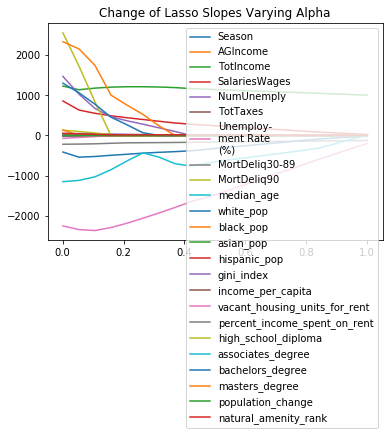

In [63]:
coefs = pd.DataFrame(np.array(coefs), columns=X_train.columns)
for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)
plt.legend(loc=0)
plt.title('Change of Lasso Slopes Varying Alpha')

In [54]:
lm.fit(X_train, y_train)

print('Linear Model')
print('-'*20)
print("Train Score:   %.5f" % lm.score(X_train, y_train))
print("Test Score:    %.5f\n" % lm.score(X_test, y_test))

Linear Model
--------------------
Train Score:   0.67718
Test Score:    0.05847



In [55]:
lasso.fit(X_train, y_train)

print('Penalized Linear Model')
print('-'*20)
print("Train Score: %.5f" % lasso.score(X_train, y_train))
print("Test Score:  %.5f" % lasso.score(X_test, y_test))

Penalized Linear Model
--------------------
Train Score: 0.64900
Test Score:  0.64157


In [57]:
from sklearn.metrics import mean_squared_error

def expo(list_):
    return list(map(exp, list_))

print('Final Model')
print('-'*20)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)#lin_mod

    
print("R^2 Score:  %.2f" % (100*lm.score(X_train, y_train)))
print("Mean Error: $%.0f\n" % mean_squared_error(y_test, y_pred))


Final Model
--------------------
R^2 Score:  67.72
Mean Error: $403563



In [59]:
# Instantiate, fit, predict
from sklearn.metrics import r2_score 


lin_mod.fit(X_train, y_train)
y_pred = lm.predict(X_test)

# Coefficient estimates
print('Coefficients: \n', lin_mod.coef_)

# Mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score
print('R_squared score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-1.52898291e+01  1.06258171e+00 -1.08879383e+00  4.31478558e-02
  4.89777943e+01  2.62858205e-01 -7.14965990e+01 -2.16507300e+02
  1.34428214e+02  1.67733102e+00 -2.96815164e+02  2.21197792e+02
  1.26933357e+03  9.37095453e+02  1.60684247e+03  1.54432520e-02
 -2.23443558e+03  2.31680474e+01  2.29210718e+03 -1.45505699e+03
  1.32779261e+03  2.11029125e+03  3.81395898e-01  5.51955040e+01]
Mean squared error: 403562.96
R_squared score: 0.06


In [208]:
res_x = [target/1000 for target in expo(y_test)]
res_y = [(target - predict)/1000 for (target, predict) in zip(expo(y_test), expo(lm.predict(y_pred)))]
plt.figure(figsize=(8,8))
plt.scatter(res_x, res_y, alpha = 0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Actual House Price in $K')
plt.ylabel('Residual House Price in $K')

OverflowError: math range error

In [ ]:
#feature engineering

#Median_age of each zipcode



In [22]:
X_train.columns

Index(['SizeRank', 'Season', 'AGIncome', 'TotIncome', 'SalariesWages',
       'NumUnemply', 'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'RentalVacancyRate', 'white', 'black', 'asian', 'NHOPI',
       'hispanic_latino', '20_to_24', '25_to_34', '35_to_44', '45_to_54',
       '55_to_59', '60_to_64', '65_to_74', '75_to_85', '85_over',
       'Population'],
      dtype='object')

In [ ]:
#drop 'SizeRank',

#1 # keep ordinal'Season'

# drop 'AGIncome', 'TotIncome', 'SalariesWages', Unemploy-\nment Rate\n(%)', 

#2 #Keep'TotTaxes', 

#3 #''NumUnemply', 

#4 #'MortDeliq30-89',

#5 #'MortDeliq90', 

#6 #'RentalVacancyRate', 

#7-9 'white', 'black', 'asian', 'NHOPI',
       
# drop for now'hispanic_latino', 

#10 # Feature engineer to be median age '20_to_24', '25_to_34', '35_to_44', '45_to_54','55_to_59', '60_to_64', '65_to_74', '75_to_85', '85_over',

# drop'Population'

In [141]:
train_set = pd.concat([X_train, y_train], axis=1)

In [142]:
train_set.head()

,income_per_capita,median_age,white_pop,black_pop,asian_pop,hispanic_pop,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,value
0,68995.0,0.000442,0.540569,0.090324,0.097815,0.240713,4.1,0.8,0.7,29.4,0.063561,0.027569,0.227130,0.176167,3727.0
1,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,4.5,0.0,0.0,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
2,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,5.1,2.2,1.9,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
3,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,3.8,0.0,0.0,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
4,114641.0,0.000693,0.720308,0.033488,0.108479,0.109406,4.1,0.8,0.7,23.9,0.047436,0.017541,0.257990,0.245017,3609.0


In [147]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and asian_pop")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'value ~ asian_pop', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and asian_pop
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:43:48   Log-Likelihood:            -4.1841e+05
No. Observations:               54620   AIC:                         8.368e+05
Df Residuals:                   54618   BIC:                         8.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [148]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and income_per_capita")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'value ~ income_per_capita', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and income_per_capita
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                 1.891e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:44:04   Log-Likelihood:            -4.1701e+05
No. Observations:               54620   AIC:                         8.340e+05
Df Residuals:                   54618   BIC:                         8.340e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

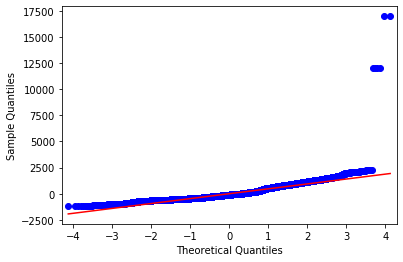

In [149]:
#Q-Q plot for normality
fig4=sm.qqplot(reg1.resid, line='r')

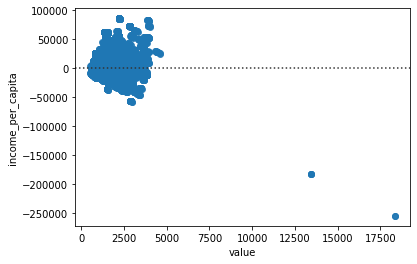

In [151]:
# simple plot of residuals
import seaborn as sns

sns.residplot('value', 'income_per_capita', data=train_set)

In [159]:
train_set.columns

Index(['income_per_capita', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'Unemploy-\nment Rate\n(%)',
       'MortDeliq30-89', 'MortDeliq90', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'value'],
      dtype='object')

In [176]:
print ("\n\n---------------------")
print ("TRAIN SET INFORMATION")
print ("---------------------")
print ("Shape of training set:", train_set.shape, "\n")
print ("Column Headers:", list(train_set.columns.values), "\n")
print (train_set.dtypes)



---------------------
TRAIN SET INFORMATION
---------------------
Shape of training set: (54620, 15) 

Column Headers: ['income_per_capita', 'median_age', 'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89', 'MortDeliq90', 'percent_income_spent_on_rent', 'high_school_diploma', 'associates_degree', 'bachelors_degree', 'masters_degree', 'value'] 

income_per_capita               float64
median_age                      float64
white_pop                       float64
black_pop                       float64
asian_pop                       float64
hispanic_pop                    float64
Unemploy-\nment Rate\n(%)       float64
MortDeliq30-89                  float64
MortDeliq90                     float64
percent_income_spent_on_rent    float64
high_school_diploma             float64
associates_degree               float64
bachelors_degree                float64
masters_degree                  float64
value                           float64
d

In [177]:
import re
missing_values = []
nonumeric_values = []

print ("TRAINING SET INFORMATION")
print ("========================\n")

for column in train_set:
    # Find all the unique feature values
    uniq = train_set[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("~~Listing up to 10 unique values~~")
    print (uniq[0:10])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(train_set[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAINING SET INFORMATION

'income_per_capita' has 1608 unique values
~~Listing up to 10 unique values~~
[ 68995.  69983. 114641.  48249.  73991.  30677.  26893.  22610.  39257.
  24798.]

-----------------------------------------------------------------------

'median_age' has 1640 unique values
~~Listing up to 10 unique values~~
[0.00044182 0.00044506 0.00069253 0.00032875 0.00043005 0.00053641
 0.00031554 0.00027878 0.00054792 0.00033241]

-----------------------------------------------------------------------

'white_pop' has 1640 unique values
~~Listing up to 10 unique values~~
[0.54056918 0.81037901 0.72030757 0.51182761 0.79384834 0.20799487
 0.29420933 0.09150449 0.55763427 0.11041575]

-----------------------------------------------------------------------

'black_pop' has 1639 unique values
~~Listing up to 10 unique values~~
[0.09032443 0.02827268 0.03348831 0.07157028 0.04209327 0.06111004
 0.15225373 0.02380314 0.17136453 0.65292197]

----------------------------------------

In [178]:
# Check for duplicate index or rows
idsUnique = len(set(train_set.index))
idsTotal = train_set.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 54620 total entries


In [179]:
#get summary of numerical variables
train_set.describe()

,income_per_capita,median_age,white_pop,black_pop,asian_pop,hispanic_pop,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,value
count,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000
mean,35310.429696,0.001272,0.549537,0.149582,0.073754,0.190990,4.401668,0.584074,0.378962,30.853182,0.129229,0.049854,0.160802,0.075925,1451.298792
std,16932.269793,0.001101,0.241982,0.184604,0.087030,0.182757,1.410166,0.966769,0.655935,4.856297,0.053856,0.018496,0.079110,0.048576,580.814489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,541.000000
25%,23420.500000,0.000735,0.382418,0.027370,0.020537,0.061989,3.600000,0.000000,0.000000,27.500000,0.087329,0.036387,0.098236,0.039104,1035.750000
50%,31472.000000,0.001043,0.589044,0.079101,0.042825,0.128981,4.200000,0.000000,0.000000,30.300000,0.131911,0.048876,0.154487,0.066141,1335.000000
75%,43521.500000,0.001505,0.745745,0.189452,0.096552,0.245951,5.000000,1.200000,0.700000,33.500000,0.169399,0.061854,0.213617,0.107515,1724.000000
max,154723.000000,0.015890,0.973506,0.982393,0.726602,0.977026,14.600000,6.400000,3.600000,50.000000,0.279457,0.126473,0.462318,0.344235,18349.000000


In [180]:
# Skewness of the distribution

print(train_set.skew())

# Values close to 0 show less skew


income_per_capita               1.612365
median_age                      7.017474
white_pop                      -0.499358
black_pop                       2.174977
asian_pop                       2.658967
hispanic_pop                    1.646705
Unemploy-\nment Rate\n(%)       1.013576
MortDeliq30-89                  1.607193
MortDeliq90                     1.717386
percent_income_spent_on_rent    0.588533
high_school_diploma             0.047329
associates_degree               0.442241
bachelors_degree                0.520415
masters_degree                  0.875553
value                           2.476307
dtype: float64


In [181]:
# Skewness of the distribution

print(train_set.kurt())

income_per_capita                4.086358
median_age                      73.662056
white_pop                       -0.711771
black_pop                        5.017894
asian_pop                        8.898027
hispanic_pop                     2.494149
Unemploy-\nment Rate\n(%)        5.123888
MortDeliq30-89                   2.146365
MortDeliq90                      2.085096
percent_income_spent_on_rent     2.098374
high_school_diploma             -0.765055
associates_degree                0.230890
bachelors_degree                -0.133190
masters_degree                   0.454484
value                           40.194009
dtype: float64


In [183]:
#Check when a value in a cloumn is zero
train_set[(train_set['value'] == 0)].count()

income_per_capita               0
median_age                      0
white_pop                       0
black_pop                       0
asian_pop                       0
hispanic_pop                    0
Unemploy-\nment Rate\n(%)       0
MortDeliq30-89                  0
MortDeliq90                     0
percent_income_spent_on_rent    0
high_school_diploma             0
associates_degree               0
bachelors_degree                0
masters_degree                  0
value                           0
dtype: int64

In [184]:
df = train_set[['income_per_capita','value']]


In [185]:
df.head()


,income_per_capita,value
0,68995.0,3727.0
1,69983.0,1735.0
2,69983.0,1735.0
3,69983.0,1735.0
4,114641.0,3609.0


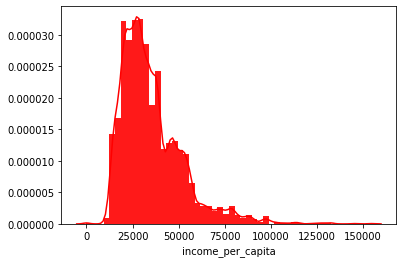

In [187]:
#draw a histogram and not fit a kernel density estimate (KDE).
sns.distplot(df['income_per_capita'], kde = True, color = 'r', hist_kws={'alpha': 0.9})

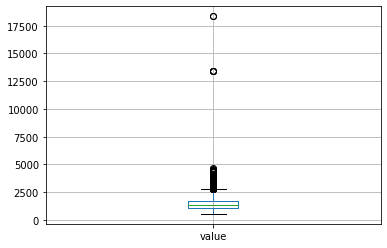

In [189]:
train_set.boxplot(column="value")
#sns.boxplot(x='value', y='Year', data=train_set)

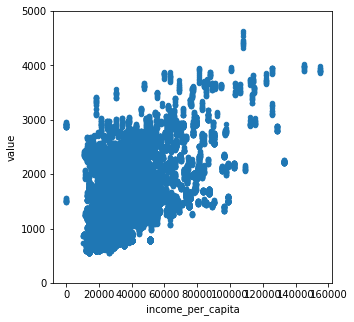

In [193]:
train_set.plot(kind="scatter",     # Create a scatterplot
              x="income_per_capita",          # Put carat on the x axis
              y=np."value",          # Put price on the y axis
              figsize=(5,5),
              ylim=(0,5000))